In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00


## Model schema


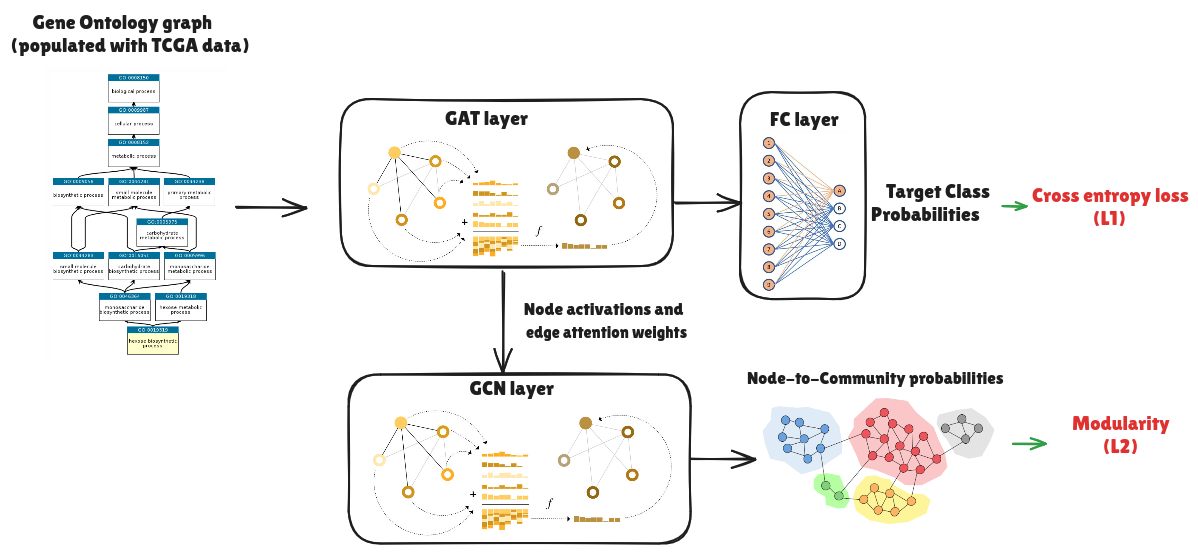

The model involves two outputs, one giving target class probabilities through a GAT model layer. And the other giving ontology class to community probabilities throgh a GCN layer which uses the node activation and attention values from GAT layer. The training is done by optimizing the losses L1+λL2, which trains both model layers (GAT and GCN) for target classification and community optimization. (λ is set to 1 in current version but it can be a hyperparameter to optimize)

In [15]:
import torch
from torch import nn
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader, Batch
from torch.nn.init import xavier_uniform_, zeros_
from torch_geometric.utils import subgraph
import numpy as np
from torch import Tensor
from torch.nn import Linear, Parameter
from torch.nn import functional as F
from torch_geometric.nn import MessagePassing
import networkx as nx
from torch_geometric.typing import Adj, OptTensor, Size
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import add_self_loops
from typing import Union, Tuple, Callable, Optional
from matplotlib import pyplot as plt
%matplotlib inline

class GATEncoder(nn.Module):
    """GAT-based model layer with attention value extraction"""
    def __init__(self, in_dim, out_dim, heads=1):
        super().__init__()
        self.conv1 = GATConv(in_dim, out_dim, heads=heads)

    def forward(self, x, edge_index):
        # Returns node features and attention weights
        x_out, (edge_index, attn_weights) = self.conv1(x, edge_index,
                                                     return_attention_weights=True)
        return F.elu(x_out), attn_weights.mean(dim=1)  # Average multi-head attention

class GNNEncoder(nn.Module):
    """GCN model layer."""
    def __init__(self, in_dim, hidden_dim, num_communities):
        super().__init__()
        self.conv1 = GCNConv(in_dim, num_communities)
        self.conv2 = GCNConv(hidden_dim, num_communities)
        self.act = nn.LeakyReLU(0.2),
        self.norm = nn.LayerNorm(num_communities)

    def forward(self, x, edge_index, edge_weight=None):

        edge_index, _ = add_self_loops(
        edge_index, edge_weight, fill_value=1e-10, num_nodes=x.size(0)
        )

        x1 = F.leaky_relu(self.conv1(x, edge_index, edge_weight=edge_weight))#self.norm(F.relu(self.conv1(x, edge_index)))
        #x1 = F.leaky_relu(self.conv2(x1, edge_index, edge_weight=edge_weight))
        x1 = self.norm(x1)
        return x1

class OntologyNNC(nn.Module):
    """
    PyTorch graph neural network model using tabular data and an ontology graph.
    This model integrates feature data with graph propagation through GAT layer, whose node activations are used for classification
    The GAT node activations and attention values are used in a separate GNN layer to assign nodes to communities.
    The model is trained for optimizing cross entropy loss (from classfication) + modularity loss (to ensure meaningful community detection)

    Args:
        n_features (int): Number of input features (number of gene expressions).
        n_nodes (int): Total number of nodes in the ontology graph (ontology class terms).
        n_nodes_annot (int): Number of nodes(ontology classes) with embeddings.
        n_prop1 (int): Number of channels for the first propagation layer (dimension of node embeddings).
        adj_mat_fc1 (torch.Tensor): Adjacency matrix for feature-to-class node mapping in the ontology.
        out_channels (int, optional): Number of output channels. Defaults to 1.
        heads (int, optional): Number of attention heads. Defaults to 1.
        num_communities (int, optional): Number of communities. Defaults to 3.
    """

    def __init__(
        self,
        n_features,
        n_nodes,
        n_nodes_annot,
        n_prop1,
        adj_mat_fc1,
        out_channels=1,
        heads=1,
        num_communities=3,
        task='regression',
        dropout_rate=0.3
    ):
        super(OntologyNNC, self).__init__()

        # Store the input parameters
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_nodes_annot = n_nodes_annot
        self.n_prop1 = n_prop1
        self.out_channels = out_channels
        self.task = task
        self.heads = heads
        self.num_communities = num_communities


        # Convert adjacency matrix to a non-trainable torch tensor
        adj_mat_fc1 = torch.tensor(adj_mat_fc1, dtype=torch.float).t()
        self.adj_mat_fc1 = Parameter(adj_mat_fc1, requires_grad=False)

        # Define the first fully connected layer (feature to node mapping)
        self.fc1 = Linear(in_features=n_features, out_features=n_nodes_annot)

        # Define the GNN encoder to detect communities
        self.GNNencoder = GNNEncoder(self.n_prop1, 16, self.num_communities)

        # Define the GAT encoder to propagate ontology features
        self.encoder = GATEncoder(self.n_prop1, 1)

        #Apply the mask to the weights of the first layer
        with torch.no_grad():
            self.fc1.weight.mul_(self.adj_mat_fc1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)


        self.classifier = nn.Linear(self.n_nodes, self.out_channels)


    def forward(self, feature_data, graph_data, mask=None):
        """Runs the forward pass of the module."""

        edge_index, batch = graph_data.edge_index, graph_data.batch

        # Initialize the node embeddings from the feature data using the fc1 layer (this step populates the gene ontology classes with data)
        initial_embedding = self.fc1(feature_data)

        x = initial_embedding

        data_list = []
        for sample in x:
            # Reshape sample to (num_nodes, 1)
            sam = torch.tensor(sample, dtype=torch.float32).view(-1, 1)
            data_obj = Data(x=sam, edge_index=edge_index)

            if mask is not None:
                data_obj.x = data_obj.x * (1 - mask)

            data_list.append(data_obj)

        # # Create a DataLoader to batch the data with graphs
        loader = torch_geometric.loader.DataLoader(data_list, batch_size=len(x), shuffle=False)

        pred = []
        out = x.new_zeros(x.shape)
        all_comm_assn = []
        for i, data in enumerate(loader):

            x_enc, attn_weights = self.encoder(data.x, data.edge_index)

            out = x_enc.squeeze(1)

            comm_assn = self.GNNencoder(x_enc, data.edge_index, edge_weight=attn_weights)
            comm_assn = F.softmax(comm_assn, dim=-1)

            # Get the number of nodes for each graph in the batch
            batch_size = len(data_list)  # or whatever your batch size is
            num_nodes = comm_assn.shape[0] // batch_size
            all_comm_assn = comm_assn.reshape(batch_size, num_nodes, self.num_communities)

        x = out.reshape(x.shape)

        x = self.classifier(x)

        if self.task == 'classification':
          if self.out_channels == 1:
            x = torch.sigmoid(x)
          else:
            x = F.softmax(x, dim=1), all_comm_assn

        return x


### Model training and dataloader functions

In [27]:
import pandas as pd
import numpy as np
import argparse
import json
import pickle
import os
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch_geometric.data import Data, Batch
import datetime
import matplotlib
import warnings
matplotlib.use('Agg')
warnings.filterwarnings('ignore')
%matplotlib inline

# Argument parser
def parse_args():
    parser = argparse.ArgumentParser(description="Train a GNN model using ontology-based modeling with important community detection")
    parser.add_argument("--dataset", type=str, required=True, help="Path to the dataset directory")
    parser.add_argument("--n_communities", type=int, required=True, help="number of communities")
    #parser.add_argument("--ontology_graph", type=str, required=False, help="Path to the ontology graph (pickle)")
    parser.add_argument("--epochs", type=int, required=True, help="Number of training epochs")

    parser.add_argument("--save", type=bool, default=False,
                        help="save the model checkpoint")

    return parser.parse_args()

def load_data(dataset_path, device, ontology_graph=None):

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if not dataset_path:
        raise ValueError("Error: dataset directory path is required.")

    features = None
    target = None

    try:
        if "tcga" in dataset_path.lower():
            loaded_data = np.load(os.path.join(dataset_path, 'tcga.npz'))

            # Extract training and testing data
            X_train, X_test, y_train, y_test = loaded_data['X_train'], loaded_data['X_test'], loaded_data['y_train'], loaded_data['y_test']

            # If ontology graph is provided, load and process it
            #if ontology_graph:
            graph_path = os.path.join(dataset_path, 'tcga_graph.pickle')

            # Check if the graph file exists
            try:
                with open(graph_path, 'rb') as f:
                    graph = pickle.load(f)

                G = graph
                if G.is_directed():
                    edge_index = [(u, v) for u, v, _ in G.edges(data=True)]
                    edge_index = torch.tensor(edge_index, dtype=torch.long).T.to(device)
                else:
                    print("Graph is undirected.")
            except FileNotFoundError:
                raise FileNotFoundError(f"Error: The graph file '{graph_path}' was not found.")
            # else:
            #     raise FileNotFoundError(f"Error: The graph file '{graph_path}' was not found.")

            try:
                matrix_connections = pd.read_csv(os.path.join(dataset_path, 'matrix_connection_truncated.csv'))
                feature_map = matrix_connections.iloc[:, 1:].values
                ontology_node_list = matrix_connections.columns[1:].values

            except FileNotFoundError:
                raise FileNotFoundError(f"Error: The feature->node connection matrix file was not found.")


            print('loaded tcga data')
            return X_train, X_test, y_train, y_test, feature_map, edge_index, ontology_node_list


        elif "titanic" in dataset_path.lower():
            data = pd.read_csv(os.path.join(dataset_path, "titanic.csv"))
            # Select relevant features
            features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinClass']
            target = 'Survived'

            # Handle missing values
            data.dropna(inplace=True)

            # Encode categorical variables
            le = LabelEncoder()
            data['Sex'] = le.fit_transform(data['Sex'])
            data['Embarked'] = le.fit_transform(data['Embarked'].astype(str))

            # Scale numerical values
            scaler = StandardScaler()
            data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])

            # Extract cabin class
            def extract_cabin_class(cabin):
                if pd.isna(cabin):
                    return 'Unknown'
                else:
                    return cabin[0]

            data['CabinClass'] = data['Cabin'].apply(extract_cabin_class)
            data['CabinClass'] = le.fit_transform(data['CabinClass'])

            np.random.seed(42)
            X_train, X_test, y_train, y_test = train_test_split(
             data[features], data['Survived'], test_size=0.2, random_state=42)

            try:

                ontology_path = os.path.join(dataset_path, "titanic_ontology.json")
                # Process ontology
                with open(ontology_path, "r") as file:
                    ont = json.load(file)

                ontology_mapping = ont["class_features_mapping"]
                ontology_relationships = ont["class_relationships"]

                n_features = len(features)
                n_nodes = len(ontology_mapping)  # Number of ontological nodes
                adj_mat_fc1 = np.zeros((n_features, n_nodes))

                # Assign connections based on the provided mapping
                feature_to_node_index = {feature: i for i, feature in enumerate(features)}
                node_to_index = {node: i for i, node in enumerate(ontology_mapping)}

                for feature, node_list in ontology_mapping.items():
                    for feature_name in node_list:
                        if feature_name in feature_to_node_index:
                            adj_mat_fc1[feature_to_node_index[feature_name], node_to_index[feature]] = 1

                feature_map = adj_mat_fc1
                ontology_node_list = ontology_mapping.keys()
                # Create edge_index tensor and move to device
                edge_index = torch.tensor(ontology_relationships, dtype=torch.long).t().contiguous().to(device)

            except FileNotFoundError:
                raise FileNotFoundError(f"Error: The feature->node connection matrix file was not found.")

            print('loaded titanic dataset')

            return X_train.values, X_test.values, y_train.values, y_test.values, feature_map, edge_index, ontology_node_list

    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The dataset file '{dataset_path}' was not found.")

    except KeyError as e:
        raise KeyError(f"Error: The expected key '{e}' was not found in the dataset.")

    except Exception as e:
        raise Exception(f"An unexpected error occurred: {str(e)}")

def get_communities(model, feature_data, graph, device='cpu'):

    feature_data = feature_data.to(device)
    edge_index, batch = graph.edge_index, graph.batch

    initial_embedding = model.fc1(feature_data)

    #Added ReLU activation after fc1 layer
    x = initial_embedding
    # x = self.relu(x)

    data_list = []
    for sample in x:
        # Reshape sample to (num_nodes, 1)
        sam = torch.tensor(sample, dtype=torch.float32).view(-1, 1)
        data_obj = Data(x=sam, edge_index=edge_index)
        data_list.append(data_obj)

    # # Create a DataLoader to batch the data with graphs
    loader = torch_geometric.loader.DataLoader(data_list, batch_size=1, shuffle=False)

    all_comm_assign = []
    for data in loader:
        x = model.encoder(data.x, data.edge_index)
        _, comm_assign = model.attention(x, data.edge_index, data.batch)
        all_comm_assign.append(comm_assign[0])

    return all_comm_assign

# function to compute modularity loss (for detected communities)
def compute_modularity_loss_fast(all_comm_assign, edge_index, num_nodes):
    # Precompute reusable terms
    row, col = edge_index
    m = edge_index.size(1) // 2  # Undirected edges
    norm = 1 / (2 * m)

    # Compute degrees (vectorized)
    deg = torch.zeros(num_nodes, device=edge_index.device)
    deg.scatter_add_(0, row, torch.ones_like(row, dtype=torch.float32))

    # Precompute deg[i] * deg[j] / (2m) for all edges
    deg_prod = deg[row] * deg[col] / (2 * m)

    # Process all community assignments in parallel
    all_mod = []
    for comm_assign in all_comm_assign:
        comm_assign = F.softmax(comm_assign, dim=-1)  # Soft assignments

        # Vectorized computation of (comm_assign[i] * comm_assign[j]).sum() for all edges
        pairwise_prods = (comm_assign[row] * comm_assign[col]).sum(dim=1)

        # Compute Q in one go (vectorized)
        Q = norm * ((1 - deg_prod) * pairwise_prods).sum()

        # Maximize modularity = minimize -Q
        all_mod.append(-Q)

    return torch.stack(all_mod)

# function to compute importance of communities by masking each community and checking change in prediction loss for datapoints
def compute_community_importance(
    model,
    X_test,
    y_test,
    graph_data_batch,
    criterion,
    device,
    num_communities
):

    model.eval()
    community_importance = torch.zeros(num_communities, device=device)
    counts = torch.zeros(num_communities, device=device)

    with torch.no_grad():
        X_test = X_test#.to(device)
        y_test = y_test#.to(device)
        graph_data_batch = graph_data_batch.to(device)

        test_dataset = TensorDataset(X_test, y_test)

        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True, pin_memory=True if device.type == 'cuda' else False)

        for i, (feature_batch, target_batch) in enumerate(test_loader):
            feature_batch = feature_batch.to(device, non_blocking=True)
            target_batch = target_batch.to(device, non_blocking=True)

            output_batch, communities = model(feature_batch, graph_data_batch)
            original_loss = criterion(output_batch.squeeze(1),target_batch)
            print('sample', i)
            print('original loss:', original_loss)

            targets = target_batch

            # Iterate over communities
            for comm_idx in range(num_communities):
                # Create mask: 1 if node's dominant community is comm_idx
                comm_mask = (communities.argmax(dim=-1) == comm_idx).float()  # (B, N)

                mask_expanded = comm_mask.reshape(-1, 1)#.unsqueeze(-1)  # (B, N, 1)

                if mask_expanded.sum() > 0:
                    # Compute loss with masked nodes
                    masked_outputs, _ = model(feature_batch, graph_data_batch, mask=mask_expanded)
                    masked_loss = criterion(masked_outputs.squeeze(1), targets)
                    print('community:', comm_idx, 'number of nodes', mask_expanded.sum(), 'loss increase per node:', (masked_loss-original_loss)/mask_expanded.sum())
                    community_importance[comm_idx] += (masked_loss-original_loss)/mask_expanded.sum()
                    counts[comm_idx] += 1

                else:
                    continue
    return community_importance

# training function main
def train_model(X_train, X_test, y_train, y_test, feature_map, edge_index, device, model=None):

    # Convert to tensors (Keep them on CPU initially)
    feature_data_train = torch.Tensor(X_train)
    feature_data_test = torch.Tensor(X_test)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)

    # Batch size
    batch_size = len(X_test)

    # Create datasets and data loaders for batching
    train_dataset = TensorDataset(feature_data_train, y_train_tensor)
    test_dataset = TensorDataset(feature_data_test, y_test_tensor)

    # Ensure pin_memory=True is used only for CPU tensors
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True if device.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True if device.type == 'cuda' else False)

    n_nodes = feature_map.shape[1]

    if model is None:
        # Create the model
        model = OntologyNNC(
            n_features=feature_data_train.shape[1],
            n_nodes=n_nodes,
            n_nodes_annot=n_nodes,
            n_prop1=1,
            adj_mat_fc1=feature_map,
            num_communities=3,
            out_channels=len(y_train_tensor.unique()),
            task='classification',
            dropout_rate=0.3
        )
        model = model.to(device)

    else:
        print("Using existing model")
        model = model.to(device)

    # model.apply(init_weights)

    # Use multiple GPUs if available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    # assign different learning rates for different model layers
    learning_rates = {
      "GNNencoder.conv1.bias": 1e-06,
      "GNNencoder.conv1.lin.weight": 1e-06,
      # "GNNencoder.conv2.bias": 1e-06,
      # "GNNencoder.conv2.lin.weight": 1e-06,
      "GNNencoder.norm.weight": 1e-04,
      "GNNencoder.norm.bias": 1e-04
    }

    params = []
    for name, param in model.named_parameters():
        if name in learning_rates:
            params.append({'params': [param], 'lr': learning_rates[name]})
        else:
            params.append({'params': [param], 'lr': 0.005}) # Default learning rate

    optimizer = optim.Adam(params, weight_decay=1e-4)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    criterion = nn.CrossEntropyLoss().to(device)

    # scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5, verbose=True)

    train_losses = []
    test_losses = []
    test_mod = []
    modularities = []
    epochs = 300

    for epoch in range(epochs):
        model.train()
        batch_train_loss = 0

        mod_loss = []
        all_communities = []
        for feature_batch, target_batch in train_loader:
            feature_batch = feature_batch.to(device, non_blocking=True)
            target_batch = target_batch.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Create batched graph data on device
            graph_data_batch = Data(
                x=torch.ones(n_nodes, n_nodes, device=device),
                edge_index=edge_index.to(device),
                batch=torch.zeros(n_nodes, dtype=torch.int64, device=device)
            )

            output_batch, communities = model(feature_batch, graph_data_batch)

            modularity = torch.mean(compute_modularity_loss_fast(communities, edge_index, n_nodes))
            loss = criterion(output_batch.squeeze(1), target_batch) + 1.0*modularity

            loss.backward()
            optimizer.step()

            mod_loss.append(modularity.cpu().detach().numpy())
            batch_train_loss += loss.item()

        train_losses.append(batch_train_loss / len(train_loader))


        # Evaluate on test set
        model.eval()
        batch_test_loss = 0

        with torch.no_grad():
            for feature_batch, target_batch in test_loader:
                feature_batch, target_batch = feature_batch.to(device, non_blocking=True), target_batch.to(device, non_blocking=True)
                graph_data_batch = Data(
                    x=torch.ones(n_nodes, n_nodes, device=device),
                    edge_index=edge_index.to(device),
                    batch=torch.zeros(n_nodes, dtype=torch.int64, device=device)
                )
                output_batch, communities = model(feature_batch, graph_data_batch)


                loss = criterion(output_batch.squeeze(1), target_batch)# + mod_loss
                batch_test_loss += loss.item()

        test_losses.append(batch_test_loss / len(test_loader))
        #scheduler.step(batch_test_loss / len(test_loader))

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}', 'Modularity: ', np.mean(mod_loss))
        modularities.append(-np.mean(mod_loss))

    # Plot losses and save figure
    plt.figure()
    ax1 = plt.gca()
    ax1.plot(train_losses, label="Train Loss", color='tab:blue')
    ax1.plot(test_losses, label="Test Loss", color='tab:orange')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create second y-axis for modularity
    ax2 = ax1.twinx()
    ax2.plot(modularities, label="Modularity", color='tab:green')
    ax2.set_ylabel("Modularity", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and legend
    plt.title("Train/Test Loss and Modularity Over Epochs")
    fig = plt.gcf()
    fig.tight_layout()
    plt.savefig("loss_modularity_plot.png")
    plt.show()

    return model, feature_data_train, y_train_tensor, feature_data_test, y_test_tensor, graph_data_batch

# function to get detected communities for all individual datapoints
def get_trained_communities(model, X_train, y_train, graph_data_batch, device):
    model.eval()
    with torch.no_grad():
        # Move data to device
        X_train = X_train.to(device)
        graph_data_batch = graph_data_batch.to(device)

        # Forward pass to get predictions
        train_predictions, communities = model(X_train, graph_data_batch)
        train_predicted_labels = torch.argmax(train_predictions, dim=1).squeeze(0)  # (num_nodes,)

        # Get community assignments
        communities = [comm_assign.argmax(axis=1) for comm_assign in communities]

        # Get edge indices from the graph data
        edge_index = graph_data_batch.edge_index

        # Print label and community per node
        for i in range(len(train_predicted_labels)):
            label = train_predicted_labels[i]
            actual_label = y_train[i]
            comm = communities[i]
            print(f"Sample {i}: Predicted Label = {label}, Actual Label = {actual_label}, Node Community assignments = {comm}, Unique communities = {torch.unique(comm)}")

            # Count number of nodes in each community
            comm_counts = torch.bincount(comm)
            for comm_id, count in enumerate(comm_counts):
                print(f"    Community {comm_id}: {count.item()} nodes")

            # Count number of edges within each community and between communities
            num_communities = len(comm_counts)
            intra_edges = torch.zeros(num_communities, dtype=torch.long, device=device)
            inter_edges = torch.zeros((num_communities, num_communities), dtype=torch.long, device=device)

            # Iterate through all edges
            for edge_idx in range(edge_index.shape[1]):
                src = edge_index[0, edge_idx]
                dst = edge_index[1, edge_idx]
                src_comm = comm[src]
                dst_comm = comm[dst]

                if src_comm == dst_comm:
                    intra_edges[src_comm] += 1
                else:
                    inter_edges[src_comm, dst_comm] += 1

            # Print intra-community edges
            print("\nIntra-community edges:")
            for comm_id in range(num_communities):
                print(f"    Community {comm_id}: {intra_edges[comm_id].item()} edges")

            # Print inter-community edges
            print("\nInter-community edges:")
            for src_comm in range(num_communities):
                for dst_comm in range(num_communities):
                    if src_comm != dst_comm and inter_edges[src_comm, dst_comm] > 0:
                        print(f"    Community {src_comm} <-> {dst_comm}: {inter_edges[src_comm, dst_comm].item()} edges")

# function to compute target classification loss
def evaluate_model(model, X_train, y_train, X_test, y_test, graph_data_batch, device):
    model.eval()
    with torch.no_grad():
        # Move input data to the same device as the model
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        graph_data_batch = graph_data_batch.to(device)

        # Forward pass
        train_predictions, _ = model(X_train, graph_data_batch)
        train_predicted_labels = torch.argmax(train_predictions, dim=1)
        train_accuracy = accuracy_score(y_train.cpu(), train_predicted_labels.squeeze(0).cpu())

        test_predictions, _ = model(X_test, graph_data_batch)
        test_predicted_labels = torch.argmax(test_predictions, dim=1)
        test_accuracy = accuracy_score(y_test.cpu(), test_predicted_labels.squeeze(0).cpu())

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

### loading data and training the model

Tesla T4
cuda:0
loaded tcga data
Using existing model
Epoch [10/300], Train Loss: 1.9153, Test Loss: 2.2346 Modularity:  -0.34411016
Epoch [20/300], Train Loss: 1.6426, Test Loss: 2.0031 Modularity:  -0.34270653
Epoch [30/300], Train Loss: 1.4676, Test Loss: 1.8629 Modularity:  -0.34349695
Epoch [40/300], Train Loss: 1.4182, Test Loss: 1.7858 Modularity:  -0.34289932
Epoch [50/300], Train Loss: 1.3307, Test Loss: 1.6979 Modularity:  -0.34390378
Epoch [60/300], Train Loss: 1.3159, Test Loss: 1.6891 Modularity:  -0.34328243
Epoch [70/300], Train Loss: 1.3079, Test Loss: 1.6852 Modularity:  -0.34406704
Epoch [80/300], Train Loss: 1.3029, Test Loss: 1.6829 Modularity:  -0.34534448
Epoch [90/300], Train Loss: 1.2992, Test Loss: 1.6842 Modularity:  -0.3463836
Epoch [100/300], Train Loss: 1.2965, Test Loss: 1.6806 Modularity:  -0.3467156
Epoch [110/300], Train Loss: 1.2928, Test Loss: 1.6798 Modularity:  -0.34747046
Epoch [120/300], Train Loss: 1.2919, Test Loss: 1.6777 Modularity:  -0.347545

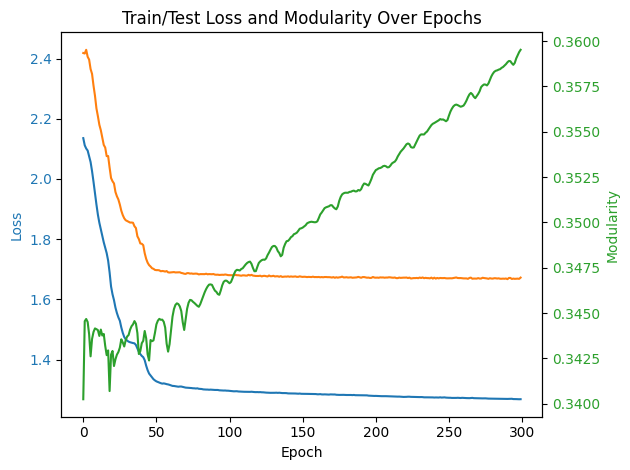

Train Accuracy: 1.0000
Test Accuracy: 0.9750


In [30]:
# data directory (titanic or tcga)
data_directory = '/content/drive/MyDrive/ontologyNN_docs/tcga'

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)

# load data
X_train, X_test, y_train, y_test, feature_map, edge_index, ontology_node_list = load_data(data_directory, device=device)

# # # # # X_train = normalize(X_train)
# # # # # # X_test = normalize(X_test)
# using only first few datapoints (for checking the training)
X_train = X_train[:1000]
X_test = X_test[:200]
y_train = y_train[:1000]
y_test = y_test[:200]

# model initialization
n_nodes = feature_map.shape[1]
num_communities = 3

model = OntologyNNC(
            n_features=X_train.shape[1],
            n_nodes=n_nodes,
            n_nodes_annot=n_nodes,
            n_prop1=1,
            adj_mat_fc1=feature_map,
            num_communities=num_communities,
            out_channels=len(set(y_train)),
            task='classification',
            dropout_rate=0.3
        )

# training the model
model, X_train, y_train, X_test, y_test, graph_data_batch = train_model(X_train, X_test, y_train, y_test
            , feature_map, edge_index, device, model=model)

# checking prediction accuracy
evaluate_model(model, X_train, y_train, X_test, y_test, graph_data_batch, device)

In [31]:
# get statistics of detected communities (num of nodes and edges) for first few individual datapoints
get_trained_communities(model, X_train[:10], y_train[:10], graph_data_batch, device)

Sample 0: Predicted Label = 3, Actual Label = 3, Node Community assignments = tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), Unique communities = tensor([1, 2], device='cuda:0')
    Community 0: 0 nodes
    Community 1: 8250 nodes
    Community 2: 38 nodes

Intra-community edges:
    Community 0: 0 edges
    Community 1: 13110 edges
    Community 2: 11 edges

Inter-community edges:
    Community 1 <-> 2: 19 edges
    Community 2 <-> 1: 54 edges
Sample 1: Predicted Label = 2, Actual Label = 2, Node Community assignments = tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), Unique communities = tensor([1, 2], device='cuda:0')
    Community 0: 0 nodes
    Community 1: 8255 nodes
    Community 2: 33 nodes

Intra-community edges:
    Community 0: 0 edges
    Community 1: 13097 edges
    Community 2: 16 edges

Inter-community edges:
    Community 1 <-> 2: 35 edges
    Community 2 <-> 1: 46 edges
Sample 2: Predicted Label = 0, Actual Label = 0, Node Community assignments = tensor([1, 1, 1,

In [32]:
# determining which community is most important by computing loss change from masking

# checking just the loss for target classifications
criterion = nn.CrossEntropyLoss()

community_importance = compute_community_importance(model, X_test[:20], y_test[:20], graph_data_batch, criterion, device, 3)

sample 0
original loss: tensor(1.6410, device='cuda:0')
community: 1 number of nodes tensor(8259., device='cuda:0') loss increase per node: tensor(7.1870e-05, device='cuda:0')
community: 2 number of nodes tensor(29., device='cuda:0') loss increase per node: tensor(0.0005, device='cuda:0')
sample 1
original loss: tensor(1.6334, device='cuda:0')
community: 1 number of nodes tensor(8271., device='cuda:0') loss increase per node: tensor(9.7571e-05, device='cuda:0')
community: 2 number of nodes tensor(17., device='cuda:0') loss increase per node: tensor(0.0015, device='cuda:0')
sample 2
original loss: tensor(1.6225, device='cuda:0')
community: 1 number of nodes tensor(8262., device='cuda:0') loss increase per node: tensor(0.0001, device='cuda:0')
community: 2 number of nodes tensor(26., device='cuda:0') loss increase per node: tensor(0.0005, device='cuda:0')
sample 3
original loss: tensor(1.6195, device='cuda:0')
community: 1 number of nodes tensor(8249., device='cuda:0') loss increase per 

([<matplotlib.axis.XTick at 0x7d1015d12c10>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

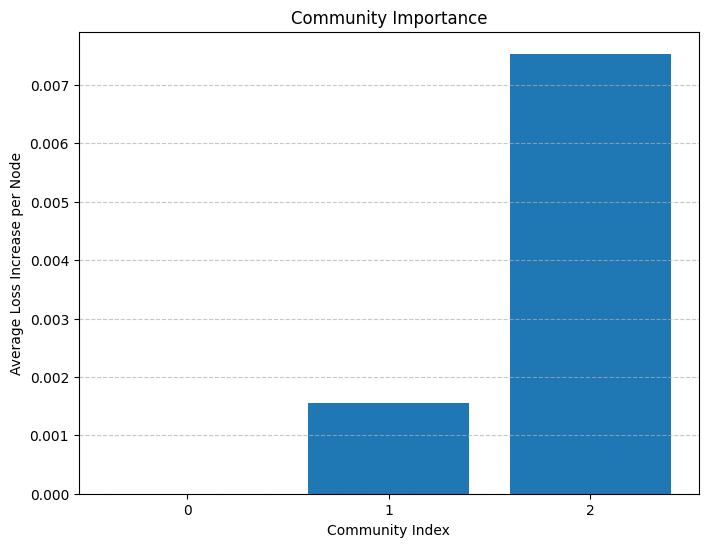

In [35]:
plt.figure(figsize=(8, 6))
plt.bar(range(num_communities), community_importance.cpu().numpy())
plt.xlabel("Community Index")
plt.ylabel("Average Loss Increase per Node")
plt.title("Community Importance")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(range(num_communities))